In [4]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [5]:
def load_mnist(path, kind):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels



In [6]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size


In [21]:
X_train, y_train = load_mnist('data/fashion', kind='train')

X_test, y_test = load_mnist('data/fashion', kind='t10k')


#Normal Kmeans Algorithm

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train)

predicted_labels=model.predict(X_test)


from sklearn.metrics import confusion_matrix

print ('Kmeans Only\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

print('\nAccuracy=',acc(y_test,predicted_labels))


from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,predicted_labels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,predicted_labels))

Kmeans Only


Confusion Matrix: 

[[ 29   6 587   0  93   1  34 245   5   0]
 [890   0  50   0  22   0   9  29   0   0]
 [  4   4  19   0  61   0 566 342   4   0]
 [503   2 277   0  92   0  10 113   3   0]
 [ 27   4 136   0  42   0 627 159   5   0]
 [  0   0   0  72 650 227   0   6   0  45]
 [ 12  15 189   0 115   0 311 358   0   0]
 [  0   0   0 151  62 785   0   0   0   2]
 [  6 351   3   9  84  40  62  36 408   1]
 [  0   0   0 519  29  23   0   4   2 423]]

Accuracy= 0.4828
NMI Score Accuracy: 0.5127573568302513
AMI Score Accuracy: 0.500295735526428


In [22]:
#Autoencoder Simple version

# input dimension = 784
input_dim = X_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

#create an encoder model from above to view the encoded image
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

Compression factor: 24.5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.4124 - val_loss: 0.3409
Epoch 2/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3262 - val_loss: 0.3193
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3115 - val_loss: 0.3086
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3022 - val_loss: 0.3007
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2957 - val_loss: 0.2952
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2912 - val_loss: 0.2919
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2887 - val_loss: 0.2900
Epoch 8/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2872 - val_loss: 0.2888
Epoch 9/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2862 - val_loss: 0.2879
Epoch

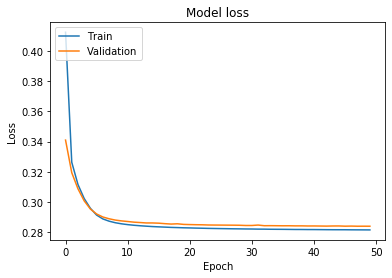

In [23]:
#Train the autoencoder model
X_train, y_train = load_mnist('data/fashion', kind='train')

X_test, y_test = load_mnist('data/fashion', kind='t10k')


X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


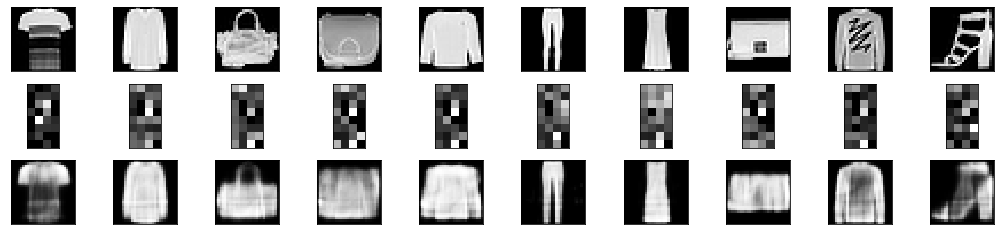

In [24]:
#viewing my autoencoder

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
#Now perform dimension reduction

X_train_dr=encoder.predict(X_train)
X_test_dr=encoder.predict(X_test)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)



from sklearn.metrics import confusion_matrix

print ('Kmeans after Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

print('\nAccuracy=',acc(y_test,predicted_labels))

from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,predicted_labels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,predicted_labels))

Kmeans after Autoencoder


Confusion Matrix: 

[[ 25   1 123 103   1  19   0 502 226   0]
 [  1   0  65  41 836   3   0   3  51   0]
 [203   0  17 280   0 354   0   5 140   1]
 [  9   0 514 154 162  23   0  17 121   0]
 [120   0 122 126   1 582   0   1  47   1]
 [  5 262   0 173   0   0  34   0 463  63]
 [133   0  92 260   2 223   0 101 189   0]
 [  0 713   0   2   0   0   2   0  67 216]
 [366  55  11 249   0   5   0   2 103 209]
 [  0  22   1  59   0   0 434   0  19 465]]

Accuracy= 0.4721
NMI Score Accuracy: 0.4428458108363314
AMI Score Accuracy: 0.4374500062490095


In [26]:
from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 

print('Results for CNN Autoencoder with Gaussian Mixture Model \n\n')


from sklearn.metrics import confusion_matrix

print ('GMM after Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

print('\nAccuracy=',acc(y_test,plabels))

from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,plabels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,plabels))

Results for CNN Autoencoder with Gaussian Mixture Model 


GMM after Autoencoder


Confusion Matrix: 

[[  0   0 206 735  43   1   2   8   5   0]
 [  0   0  41   4 128 825   0   0   2   0]
 [  0   0 216  12   8   0   1 741  22   0]
 [  0   0 139  55 720  59   0   9  18   0]
 [  0   0 201   5  93   0   1 665  35   0]
 [  3 455   2   0   0   0 179   0   8 353]
 [  0   0 231 247  23   0   7 480  12   0]
 [211 742   0   0   0   0  38   0   0   9]
 [  0   6 595   0   5   0 303   1  81   9]
 [354  16   1   0   0   0  20   0  11 598]]

Accuracy= 0.517
NMI Score Accuracy: 0.5754044979283558
AMI Score Accuracy: 0.5589152422622269


In [27]:
#Deep autoencoder model

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

#encoder model

input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
________________________________________________

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.3763 - val_loss: 0.3194
Epoch 2/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3110 - val_loss: 0.3076
Epoch 3/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3024 - val_loss: 0.3035
Epoch 4/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2975 - val_loss: 0.2981
Epoch 5/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2947 - val_loss: 0.2956
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.2924 - val_loss: 0.2944
Epoch 7/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.2904 - val_loss: 0.2939
Epoch 8/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.2888 - val_loss: 0.2900
Epoch 9/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2873 - val_loss: 0.2897
Epoch

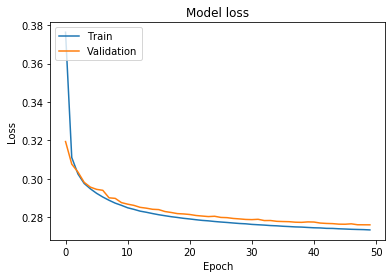

In [28]:
#Training the model

X_train, y_train = load_mnist('data/fashion', kind='train')

X_test, y_test = load_mnist('data/fashion', kind='t10k')

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                validation_data=(X_test, X_test))


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


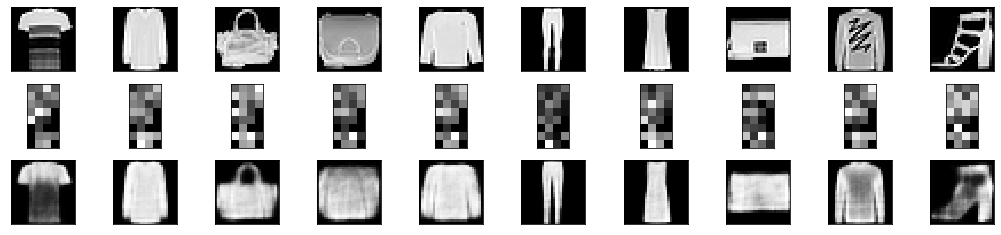

In [29]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
#Now perform dimension reduction

X_train_dr=encoder.predict(X_train)
X_test_dr=encoder.predict(X_test)


#then perform Kmeans

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)



from sklearn.metrics import confusion_matrix

print ('Kmeans after Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

print('\nAccuracy=',acc(y_test,predicted_labels))


from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,predicted_labels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,predicted_labels))

Kmeans after Autoencoder


Confusion Matrix: 

[[549  12   0  10   0 262   1  35   1 130]
 [ 84   1   0 586   0  39 252   6   0  32]
 [ 20  19   0   0   0 381   0 552   0  28]
 [214   4   0 170   0 122 146  11   0 333]
 [ 48  16   0   4   0 204   0 585   0 143]
 [  0 115 287   0 232  83   0   0 283   0]
 [180  36   0   2   0 417   2 290   0  73]
 [  0  37 544   0  25   3   0   0 391   0]
 [ 63 554   6   0   0 222   0  45 106   4]
 [  0  57  24   0 635  30   0   0 254   0]]

Accuracy= 0.4486
NMI Score Accuracy: 0.45161249315213337
AMI Score Accuracy: 0.4437916605738921


In [31]:
from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 

print('Results for CNN Autoencoder with Gaussian Mixture Model \n\n')


from sklearn.metrics import confusion_matrix

print ('GMM after Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

print('\nAccuracy=',acc(y_test,plabels))

from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,plabels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,plabels))

Results for CNN Autoencoder with Gaussian Mixture Model 


GMM after Autoencoder


Confusion Matrix: 

[[ 12 788  40   0   0  19   2   1   0 138]
 [  1  37   8 847   0   1   0   0   0 106]
 [  5  20 819   0   0  10   1   0   0 145]
 [  2 661  72   0   0   4   1   0   0 260]
 [  1 107 753   0   0  10   0   0   0 129]
 [  0   0   0   0 397   0 351 225  24   3]
 [ 15 263 543   0   0  38   0   0   0 141]
 [  0   0   0   0 709   0   0 279  12   0]
 [411   3  38   0   3 401   2  36   0 106]
 [  0   0   0   0   3   0  27 224 737   9]]

Accuracy= 0.496
NMI Score Accuracy: 0.5837661882781303
AMI Score Accuracy: 0.5625616741062637


In [7]:
#Convolution Autoencoder

X_train, y_train = load_mnist('data/fashion', kind='train')

X_test, y_test = load_mnist('data/fashion', kind='t10k')

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255



x_train = X_train.reshape((len(X_train), 28, 28, 1))
x_test = X_test.reshape((len(X_test), 28, 28, 1))



autoencoder3 = Sequential()

# Encoder Layers
autoencoder3.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder3.add(MaxPooling2D((2, 2), padding='same'))
autoencoder3.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder3.add(MaxPooling2D((2, 2), padding='same'))
autoencoder3.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder3.add(Flatten())
autoencoder3.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder3.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder3.add(UpSampling2D((2, 2)))
autoencoder3.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder3.add(UpSampling2D((2, 2)))
autoencoder3.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder3.add(UpSampling2D((2, 2)))
autoencoder3.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder3.summary()


#The encoder model based on convolution autoencoder

encoder = Model(inputs=autoencoder3.input, outputs=autoencoder3.get_layer('flatten_1').output)
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)          

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 66s 1ms/step - loss: 0.3521 - val_loss: 0.3103
Epoch 2/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.3036 - val_loss: 0.3019
Epoch 3/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.2969 - val_loss: 0.2964
Epoch 4/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.2926 - val_loss: 0.2931
Epoch 5/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.2899 - val_loss: 0.2907
Epoch 6/100
60000/60000 [==============================] - 66s 1ms/step - loss: 0.2879 - val_loss: 0.2895
Epoch 7/100
60000/60000 [==============================] - 64s 1ms/step - loss: 0.2865 - val_loss: 0.2878
Epoch 8/100
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2853 - val_loss: 0.2867
Epoch 9/100
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2844 - val_loss: 0.2

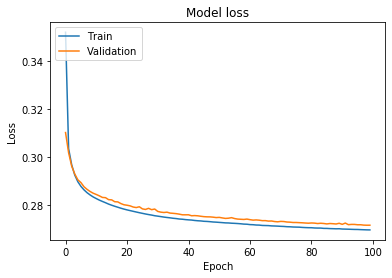

In [8]:
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder3.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, x_test))


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

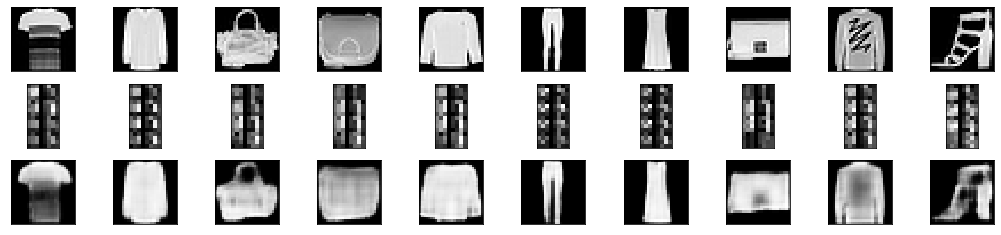

In [9]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder3.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
#Now perform dimension reduction

X_train_dr=encoder.predict(x_train)
X_test_dr=encoder.predict(x_test)

#then perform Kmeans

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)

from sklearn.metrics import confusion_matrix

print ('Kmeans after Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

print('\nAccuracy=',acc(y_test,predicted_labels))

Kmeans after Autoencoder


Confusion Matrix: 

[[635 248   5   0  50   2  55   5   0   0]
 [ 48  18   1   0  14   0 919   0   0   0]
 [ 25 318   4   0 642   0   3   8   0   0]
 [256  97   1   0  15   0 630   1   0   0]
 [159 152   2   0 645   0  36   6   0   0]
 [  0   6   0  36   0 526   0   0 337  95]
 [211 377  17   0 362   3  24   6   0   0]
 [  0   0   0   4   0 757   0   0   1 238]
 [  8  83 394   0  60  35  18 392   6   4]
 [  3   5   1 447   0  10   0   0  31 503]]

Accuracy= 0.4575


In [20]:
print('Results for CNN Autoencoder with KMeans \n\n')

from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,predicted_labels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,predicted_labels))

Results for CNN Autoencoder with KMeans 


NMI Score Accuracy: 0.5466555432256286
AMI Score Accuracy: 0.5282924772290158


In [16]:
from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 


In [17]:
from sklearn.metrics import confusion_matrix

print ('GMM after Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

print('\nAccuracy=',acc(y_test,plabels))

GMM after Autoencoder


Confusion Matrix: 

[[  0 679 196   2   9   1 113   0   0   0]
 [  0   0  32 813   0   0 155   0   0   0]
 [  0   4 216   0 765   1  14   0   0   0]
 [  0  38  88 195  32   0 647   0   0   0]
 [  0   0 138   0 742   0 120   0   0   0]
 [213   0   5   0   0  21   0 382   1 378]
 [  0 178 268   2 455   5  92   0   0   0]
 [307   0   0   0   0  14   0 665   7   7]
 [  1   0 608   1   1 337  49   2   0   1]
 [318   0   2   0   0   1   0   3 607  69]]

Accuracy= 0.5167


In [19]:
print('Results for CNN Autoencoder with Gaussian Mixture Model \n\n')

from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI Score Accuracy:',normalized_mutual_info_score(y_test,plabels))

from sklearn.metrics.cluster import adjusted_mutual_info_score

print('AMI Score Accuracy:',adjusted_mutual_info_score(y_test,plabels))

Results for CNN Autoencoder with Gaussian Mixture Model 


NMI Score Accuracy: 0.5827204881021205
AMI Score Accuracy: 0.5681009089830041
